<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/balanced_dataset_with_augmentation/notebooks/CNN_Transfer_Learning_with_over_fittingv2_accc71.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!git clone -b balanced_dataset_with_augmentation https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


In [24]:
# %pip install -U grad-cam shap lime onnx onnxruntime opencv-python seaborn scikit-learn

In [25]:
from __future__ import annotations

import os
import gc
import json
import math
import time
import random
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Optional, List, Dict, Tuple

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Explainability & Export
import pytorch_grad_cam
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
import shap
from lime import lime_image
import onnx
import onnxruntime as ort
import cv2

try:
    import timm  # for ViT and many more backbones
    TIMM_AVAILABLE = True
except Exception:
    TIMM_AVAILABLE = False

In [26]:
# --------------------------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------------------------

@dataclass
class CFG:
    # Paths - update these to your actual paths
    project_root: Path = Path('/content/ann-visual-emotion')  # your repo/project root
    csv_train: Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv')
    csv_val:   Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv')
    csv_test:  Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv')
    label_map_json: Path = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json')
    out_dir: Path = Path('/content/ann-visual-emotion/artifacts_explainability')

    image_col: str = 'path'
    label_col: str = 'label'

    # Model/backbone
    model_type: str = 'resnet50'  # 'resnet50' (CNN) or 'vit_base_patch16_224' (ViT, requires timm)
    pretrained: bool = True
    img_size: int = 224

    # Optimization
    batch_size: int = 32
    epochs: int = 50
    warmup_epochs: int = 3
    lr_backbone: float = 1e-4
    lr_head: float = 1e-3
    weight_decay: float = 1e-4
    label_smoothing: float = 0.05
    use_amp: bool = True
    grad_clip_norm: float = 1.0

    # Regularization
    use_mixup: bool = True
    mixup_alpha: float = 0.4
    use_cutmix: bool = False
    cutmix_alpha: float = 1.0

    # Early stopping
    patience: int = 10
    monitor: str = 'macro_f1'  # 'acc' or 'macro_f1'

    # EMA
    use_ema: bool = True
    ema_decay: float = 0.999

    # Class weighting / sampler
    use_class_weights: bool = True
    use_weighted_sampler: bool = False  # dataset already nearly balanced
    class_weight_alpha: float = 0.6

    # Explainability toggles
    run_gradcam: bool = True
    run_gradcam_pp: bool = True
    run_shap: bool = True
    run_lime: bool = True
    run_vit_attn: bool = True  # only if model_type is ViT

    # ONNX export
    export_onnx: bool = True
    onnx_filename: str = 'best_model.onnx'

    seed: int = 42

cfg = CFG()

In [27]:
# --------------------------------------------------------------------------------
# Utils: Seeding, Device, Paths
# --------------------------------------------------------------------------------

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For reproducibility:
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(cfg.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [28]:
# --------------------------------------------------------------------------------
# Labels and DataFrames
# --------------------------------------------------------------------------------

def load_label_map(path: Path, df: pd.DataFrame, label_col: str) -> Tuple[List[str], Dict[str,int]]:
    if path.exists():
        with open(path, 'r') as f:
            lm = json.load(f)
        label_to_id = {k: int(v) for k,v in lm.items()}
    else:
        unique = sorted(df[label_col].unique().tolist())
        label_to_id = {lbl: i for i, lbl in enumerate(unique)}
    classes = [lbl for lbl, _id in sorted(label_to_id.items(), key=lambda x: x[1])]
    return classes, label_to_id

def check_paths():
    print('Project root:', cfg.project_root)
    for p in [cfg.csv_train, cfg.csv_val, cfg.csv_test, cfg.label_map_json]:
        print(f'{p}: {"OK" if Path(p).exists() else "MISSING"}')

check_paths()

train_df = pd.read_csv(cfg.csv_train)
val_df   = pd.read_csv(cfg.csv_val)
test_df  = pd.read_csv(cfg.csv_test)

assert cfg.image_col in train_df.columns and cfg.label_col in train_df.columns, "CSV must contain image and label columns."

CLASSES, class_to_idx = load_label_map(cfg.label_map_json, train_df, cfg.label_col)
NUM_CLASSES = len(CLASSES)
print('Classes:', CLASSES)
print('Counts:', train_df[cfg.label_col].value_counts().to_dict())

Project root: /content/ann-visual-emotion
/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv: OK
/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json: OK
Classes: ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Counts: {'surprised': 9394, 'fearful': 9394, 'angry': 9393, 'happy': 9359, 'sad': 9359, 'neutral': 9359}


In [29]:
# --------------------------------------------------------------------------------
# Transforms & Dataset
# --------------------------------------------------------------------------------

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def build_transforms(img_size):
    train_tf = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.75, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.25, 0.25, 0.25, 0.10),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), value='random')
    ])
    val_tf = transforms.Compose([
        transforms.Resize(int(img_size*1.14)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
    return train_tf, val_tf

train_tf, val_tf = build_transforms(cfg.img_size)

class EmotionDataset(Dataset):
    def __init__(self, df, image_col, label_col, class_to_idx, transform=None, root: Optional[Path]=None):
        self.df = df.reset_index(drop=True)
        self.image_col = image_col
        self.label_col = label_col
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.root = Path(root) if root else None
        self.root = cfg.project_root if self.root is None else self.root

    def resolve_path(self, raw):
        p = Path(raw)
        if p.is_absolute() and p.exists(): return p
        if self.root:
            # treat raw like project-root-relative if original begins with /
            try:
                candidate = self.root / p.relative_to('/')
            except Exception:
                candidate = self.root / p
            if candidate.exists(): return candidate
        if p.exists(): return p
        raise FileNotFoundError(f'Image not found: {raw}')

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = self.resolve_path(row[self.image_col])
        label_name = row[self.label_col]
        label = self.class_to_idx[label_name]
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            if self.transform:
                img = self.transform(img)
        return img, label, str(img_path)

train_dataset = EmotionDataset(train_df, cfg.image_col, cfg.label_col, class_to_idx, transform=train_tf)
val_dataset   = EmotionDataset(val_df,   cfg.image_col, cfg.label_col, class_to_idx, transform=val_tf)
test_dataset  = EmotionDataset(test_df,  cfg.image_col, cfg.label_col, class_to_idx, transform=val_tf)

# Class weights (optional, dataset is nearly balanced)
counts = train_df[cfg.label_col].value_counts().reindex(CLASSES).values.astype(float)
if cfg.use_class_weights:
    inv = 1.0 / (counts ** cfg.class_weight_alpha)
    class_weights = inv / inv.sum() * len(CLASSES)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
else:
    class_weights_tensor = torch.ones(NUM_CLASSES, dtype=torch.float32).to(device)

if cfg.use_weighted_sampler:
    sample_weights = train_df[cfg.label_col].map({c: class_weights[i] for i,c in enumerate(CLASSES)}).values
    sampler = WeightedRandomSampler(torch.DoubleTensor(sample_weights),
                                    num_samples=len(sample_weights),
                                    replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, sampler=sampler, num_workers=2, pin_memory=True)
else:
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)

val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [30]:
# --------------------------------------------------------------------------------
# Build Model
# --------------------------------------------------------------------------------

def build_resnet50(num_classes, pretrained=True):
    m = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    feat = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Linear(feat, 512),
        nn.ReLU(inplace=True),
        nn.LayerNorm(512),
        nn.Dropout(0.25),
        nn.Linear(512, num_classes)
    )
    return m

def build_vit(num_classes, pretrained=True, model_name='vit_base_patch16_224'):
    assert TIMM_AVAILABLE, "timm is required for ViT"
    m = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
    return m

if cfg.model_type == 'resnet50':
    model = build_resnet50(NUM_CLASSES, pretrained=cfg.pretrained)
elif cfg.model_type.startswith('vit'):
    model = build_vit(NUM_CLASSES, pretrained=cfg.pretrained, model_name=cfg.model_type)
else:
    raise ValueError('Unsupported model type.')

model = model.to(device)

# Discriminative Learning Rates
def make_param_groups(model, lr_backbone, lr_head):
    backbone_params, head_params = [], []
    # Heuristic: everything except the final classifier head uses backbone LR
    head_names = ['fc', 'classifier', 'head', 'heads', 'last_layer', 'pre_logits', 'head_drop']
    head_modules = []
    for hn in head_names:
        if hasattr(model, hn):
            head_modules.append(getattr(model, hn))
    head_param_ids = set()
    for hm in head_modules:
        for p in hm.parameters(): head_param_ids.add(id(p))
    for p in model.parameters():
        if id(p) in head_param_ids:
            head_params.append(p)
        else:
            backbone_params.append(p)
    return [
        {'params': backbone_params, 'lr': lr_backbone},
        {'params': head_params,     'lr': lr_head},
    ]

optimizer = torch.optim.AdamW(make_param_groups(model, cfg.lr_backbone, cfg.lr_head), weight_decay=cfg.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)

# EMA
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.data.clone()

    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1 - self.decay)

    def apply(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                p.data.copy_(self.shadow[n])

ema = EMA(model, decay=cfg.ema_decay) if cfg.use_ema else None

# Loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=cfg.label_smoothing)

# Scheduler (Warmup + Cosine)
def cosine_warmup(epoch, total_epochs, warmup_epochs):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
    return 0.5 * (1 + math.cos(math.pi * progress))

# Mixup/CutMix
def apply_mixup(x, y, alpha=0.4):
    if alpha <= 0: return x, (y, y, 1.0), False
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, (y, y[idx], lam), True

def apply_cutmix(x, y, alpha=1.0):
    if alpha <= 0: return x, (y, y, 1.0), False
    lam = np.random.beta(alpha, alpha)
    B, C, H, W = x.size()
    idx = torch.randperm(B, device=x.device)
    rx, ry = np.random.randint(W), np.random.randint(H)
    rw = int(W * math.sqrt(1 - lam))
    rh = int(H * math.sqrt(1 - lam))
    x1, y1 = np.clip(rx - rw//2, 0, W), np.clip(ry - rh//2, 0, H)
    x2, y2 = np.clip(rx + rw//2, 0, W), np.clip(ry + rh//2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam_adjust = 1 - ((x2 - x1)*(y2 - y1)/(W*H))
    return x, (y, y[idx], lam_adjust), True

/tmp/ipython-input-2586583615.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)


Training resnet50 for 60 epochs...


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 1/60 | TrainLoss 1.3686 Acc 0.4812 | ValLoss 1.1688 Acc 0.5764 MacroF1 0.5730


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 2/60 | TrainLoss 1.3487 Acc 0.4980 | ValLoss 1.1253 Acc 0.5965 MacroF1 0.5938


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 3/60 | TrainLoss 1.3209 Acc 0.5184 | ValLoss 1.0883 Acc 0.6218 MacroF1 0.6174


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 4/60 | TrainLoss 1.2823 Acc 0.5389 | ValLoss 1.0560 Acc 0.6325 MacroF1 0.6397


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 5/60 | TrainLoss 1.2493 Acc 0.5566 | ValLoss 1.0254 Acc 0.6549 MacroF1 0.6560


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 6/60 | TrainLoss 1.2252 Acc 0.5708 | ValLoss 0.9510 Acc 0.6839 MacroF1 0.6866


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 7/60 | TrainLoss 1.2010 Acc 0.5828 | ValLoss 0.9397 Acc 0.6890 MacroF1 0.6853


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 8/60 | TrainLoss 1.1825 Acc 0.5912 | ValLoss 0.9215 Acc 0.6962 MacroF1 0.6977


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 9/60 | TrainLoss 1.1634 Acc 0.6032 | ValLoss 0.8797 Acc 0.7143 MacroF1 0.7147


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 10/60 | TrainLoss 1.1503 Acc 0.6103 | ValLoss 0.8980 Acc 0.7146 MacroF1 0.7152


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 11/60 | TrainLoss 1.1219 Acc 0.6252 | ValLoss 0.9099 Acc 0.7033 MacroF1 0.7030


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 12/60 | TrainLoss 1.1191 Acc 0.6277 | ValLoss 0.8630 Acc 0.7305 MacroF1 0.7317


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 13/60 | TrainLoss 1.1068 Acc 0.6345 | ValLoss 0.8869 Acc 0.7181 MacroF1 0.7217


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 14/60 | TrainLoss 1.0862 Acc 0.6434 | ValLoss 0.8435 Acc 0.7385 MacroF1 0.7387


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 15/60 | TrainLoss 1.0758 Acc 0.6501 | ValLoss 0.8360 Acc 0.7478 MacroF1 0.7483


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 16/60 | TrainLoss 1.0613 Acc 0.6576 | ValLoss 0.8233 Acc 0.7475 MacroF1 0.7463


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 17/60 | TrainLoss 1.0626 Acc 0.6580 | ValLoss 0.7882 Acc 0.7605 MacroF1 0.7610


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 18/60 | TrainLoss 1.0380 Acc 0.6704 | ValLoss 0.8031 Acc 0.7617 MacroF1 0.7610


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 19/60 | TrainLoss 1.0418 Acc 0.6690 | ValLoss 0.7942 Acc 0.7590 MacroF1 0.7571


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 20/60 | TrainLoss 1.0024 Acc 0.6879 | ValLoss 0.8001 Acc 0.7696 MacroF1 0.7714


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 21/60 | TrainLoss 0.9905 Acc 0.6938 | ValLoss 0.7753 Acc 0.7713 MacroF1 0.7726


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 22/60 | TrainLoss 0.9906 Acc 0.6945 | ValLoss 0.7837 Acc 0.7749 MacroF1 0.7738


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 23/60 | TrainLoss 0.9661 Acc 0.7064 | ValLoss 0.7630 Acc 0.7833 MacroF1 0.7823


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 24/60 | TrainLoss 0.9729 Acc 0.7064 | ValLoss 0.7674 Acc 0.7822 MacroF1 0.7819


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 25/60 | TrainLoss 0.9703 Acc 0.7070 | ValLoss 0.7736 Acc 0.7810 MacroF1 0.7796


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 26/60 | TrainLoss 0.9424 Acc 0.7201 | ValLoss 0.7636 Acc 0.7874 MacroF1 0.7875


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 27/60 | TrainLoss 0.9266 Acc 0.7258 | ValLoss 0.7557 Acc 0.7892 MacroF1 0.7891


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 28/60 | TrainLoss 0.9196 Acc 0.7303 | ValLoss 0.7525 Acc 0.7879 MacroF1 0.7874


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 29/60 | TrainLoss 0.9202 Acc 0.7310 | ValLoss 0.7521 Acc 0.7901 MacroF1 0.7896


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 30/60 | TrainLoss 0.9149 Acc 0.7330 | ValLoss 0.7426 Acc 0.7937 MacroF1 0.7937


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 31/60 | TrainLoss 0.8981 Acc 0.7420 | ValLoss 0.7461 Acc 0.7950 MacroF1 0.7942


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 32/60 | TrainLoss 0.8925 Acc 0.7451 | ValLoss 0.7305 Acc 0.7974 MacroF1 0.7981


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 33/60 | TrainLoss 0.8948 Acc 0.7449 | ValLoss 0.7455 Acc 0.7928 MacroF1 0.7945


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 34/60 | TrainLoss 0.8900 Acc 0.7477 | ValLoss 0.7381 Acc 0.7995 MacroF1 0.7989


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 35/60 | TrainLoss 0.8681 Acc 0.7569 | ValLoss 0.7287 Acc 0.8041 MacroF1 0.8044


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 36/60 | TrainLoss 0.8678 Acc 0.7573 | ValLoss 0.7329 Acc 0.8020 MacroF1 0.8015


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 37/60 | TrainLoss 0.8558 Acc 0.7618 | ValLoss 0.7307 Acc 0.8036 MacroF1 0.8038


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 38/60 | TrainLoss 0.8458 Acc 0.7705 | ValLoss 0.7284 Acc 0.8037 MacroF1 0.8037


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 39/60 | TrainLoss 0.8365 Acc 0.7729 | ValLoss 0.7192 Acc 0.8070 MacroF1 0.8069


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 40/60 | TrainLoss 0.8595 Acc 0.7629 | ValLoss 0.7218 Acc 0.8072 MacroF1 0.8073


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 41/60 | TrainLoss 0.8287 Acc 0.7752 | ValLoss 0.7243 Acc 0.8069 MacroF1 0.8064


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 42/60 | TrainLoss 0.8248 Acc 0.7785 | ValLoss 0.7220 Acc 0.8076 MacroF1 0.8078


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 43/60 | TrainLoss 0.8331 Acc 0.7770 | ValLoss 0.7186 Acc 0.8111 MacroF1 0.8114


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 44/60 | TrainLoss 0.8113 Acc 0.7849 | ValLoss 0.7219 Acc 0.8108 MacroF1 0.8114


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 45/60 | TrainLoss 0.8203 Acc 0.7816 | ValLoss 0.7174 Acc 0.8118 MacroF1 0.8115


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 46/60 | TrainLoss 0.8075 Acc 0.7869 | ValLoss 0.7219 Acc 0.8125 MacroF1 0.8125


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 47/60 | TrainLoss 0.8019 Acc 0.7900 | ValLoss 0.7194 Acc 0.8097 MacroF1 0.8098


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 48/60 | TrainLoss 0.8005 Acc 0.7901 | ValLoss 0.7187 Acc 0.8119 MacroF1 0.8120


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 49/60 | TrainLoss 0.7932 Acc 0.7926 | ValLoss 0.7174 Acc 0.8120 MacroF1 0.8123


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 50/60 | TrainLoss 0.8021 Acc 0.7892 | ValLoss 0.7190 Acc 0.8130 MacroF1 0.8131


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 51/60 | TrainLoss 0.7930 Acc 0.7957 | ValLoss 0.7176 Acc 0.8142 MacroF1 0.8143


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 52/60 | TrainLoss 0.7969 Acc 0.7923 | ValLoss 0.7159 Acc 0.8154 MacroF1 0.8153


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 53/60 | TrainLoss 0.7987 Acc 0.7918 | ValLoss 0.7201 Acc 0.8122 MacroF1 0.8120


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 54/60 | TrainLoss 0.7970 Acc 0.7930 | ValLoss 0.7162 Acc 0.8142 MacroF1 0.8140


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 55/60 | TrainLoss 0.7847 Acc 0.7981 | ValLoss 0.7175 Acc 0.8143 MacroF1 0.8139


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 56/60 | TrainLoss 0.7902 Acc 0.7973 | ValLoss 0.7231 Acc 0.8136 MacroF1 0.8136


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 57/60 | TrainLoss 0.7781 Acc 0.8023 | ValLoss 0.7143 Acc 0.8146 MacroF1 0.8147


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 58/60 | TrainLoss 0.7873 Acc 0.7977 | ValLoss 0.7158 Acc 0.8141 MacroF1 0.8141


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 59/60 | TrainLoss 0.7810 Acc 0.8002 | ValLoss 0.7170 Acc 0.8158 MacroF1 0.8158


/tmp/ipython-input-1793845404.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


Epoch 60/60 | TrainLoss 0.7944 Acc 0.7941 | ValLoss 0.7159 Acc 0.8149 MacroF1 0.8147
Best macro_f1 = 0.8158232297831737


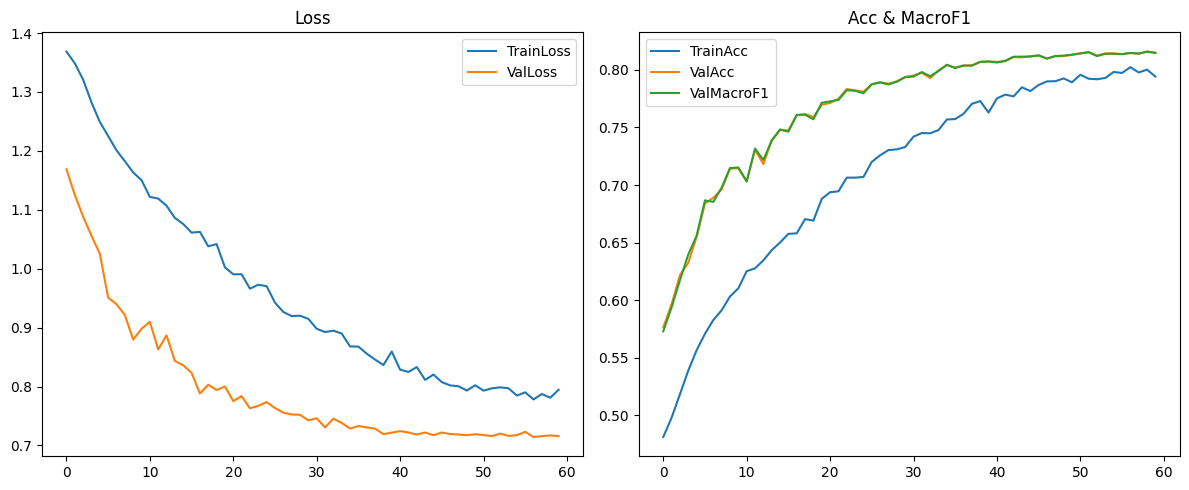

In [22]:
# --------------------------------------------------------------------------------
# Train & Evaluate
# --------------------------------------------------------------------------------

def train_one_epoch(model, loader, optimizer, device, criterion, scaler=None):
    model.train()
    total_loss, total_correct, total = 0.0, 0.0, 0
    for imgs, labels, _ in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        mixed = False
        if cfg.use_mixup and cfg.use_cutmix:
            if random.random() < 0.5:
                imgs, (ya, yb, lam), mixed = apply_mixup(imgs, labels, cfg.mixup_alpha)
            else:
                imgs, (ya, yb, lam), mixed = apply_cutmix(imgs, labels, cfg.cutmix_alpha)
        elif cfg.use_mixup:
            imgs, (ya, yb, lam), mixed = apply_mixup(imgs, labels, cfg.mixup_alpha)
        elif cfg.use_cutmix:
            imgs, (ya, yb, lam), mixed = apply_cutmix(imgs, labels, cfg.cutmix_alpha)

        with torch.cuda.amp.autocast(enabled=cfg.use_amp):
            logits = model(imgs)
            if mixed:
                loss = lam * criterion(logits, ya) + (1 - lam) * criterion(logits, yb)
            else:
                loss = criterion(logits, labels)

        if scaler:
            scaler.scale(loss).backward()
            if cfg.grad_clip_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if cfg.grad_clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
            optimizer.step()

        if ema: ema.update(model)

        bs = imgs.size(0)
        total_loss += loss.item() * bs
        preds = logits.argmax(1)
        if mixed:
            total_correct += (lam * preds.eq(ya).sum().item() + (1 - lam) * preds.eq(yb).sum().item())
        else:
            total_correct += preds.eq(labels).sum().item()
        total += bs

    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate(model, loader, device, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0.0, 0
    all_preds, all_labels = [], []
    for imgs, labels, _ in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        bs = imgs.size(0)
        total_loss += loss.item() * bs
        preds = logits.argmax(1)
        total_correct += preds.eq(labels).sum().item()
        total += bs
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    acc = accuracy_score(all_labels, all_preds)
    return total_loss / total, acc, macro_f1, all_preds, all_labels

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=10, mode='max', min_delta=0.0):
        self.patience = patience
        self.mode = mode
        self.min_delta = min_delta
        self.best = None
        self.bad = 0
        self.stop = False
    def step(self, val):
        if self.best is None:
            self.best = val
            return False
        improve = (val - self.best) if self.mode == 'max' else (self.best - val)
        if self.mode == 'max':
            if improve > self.min_delta:
                self.best = val; self.bad = 0
            else:
                self.bad += 1
        else:
            if improve > self.min_delta:
                self.best = val; self.bad = 0
            else:
                self.bad += 1
        if self.bad >= self.patience:
            self.stop = True
        return self.stop

# Train Loop
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'val_macro_f1':[]}
early_stopper = EarlyStopper(patience=cfg.patience, mode='max' if cfg.monitor=='macro_f1' else 'max')
best_metric, best_state = -1.0, None

os.makedirs(cfg.out_dir, exist_ok=True)

print(f'Training {cfg.model_type} for {cfg.epochs} epochs...')
for epoch in range(cfg.epochs):
    # Warmup + cosine
    scale = cosine_warmup(epoch, cfg.epochs, cfg.warmup_epochs)
    for g in optimizer.param_groups:
        base_lr = g.get('base_lr', g['lr'])
        g['base_lr'] = base_lr
        g['lr'] = base_lr * scale

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, criterion, scaler)
    if ema: ema.apply(model)
    val_loss, val_acc, val_macro_f1, val_preds, val_labels = evaluate(model, val_loader, device, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_macro_f1'].append(val_macro_f1)

    metric_now = val_macro_f1 if cfg.monitor == 'macro_f1' else val_acc
    if metric_now > best_metric:
        best_metric = metric_now
        best_state = {'model': model.state_dict(), 'epoch': epoch, 'val_metric': best_metric, 'config': asdict(cfg)}
        torch.save(best_state, cfg.out_dir / 'best_model.pth')

    print(f'Epoch {epoch+1}/{cfg.epochs} | TrainLoss {train_loss:.4f} Acc {train_acc:.4f} | ValLoss {val_loss:.4f} Acc {val_acc:.4f} MacroF1 {val_macro_f1:.4f}')

    if early_stopper.step(metric_now):
        print('Early stopping triggered.')
        break

print('Best', cfg.monitor, '=', best_metric)

# Plot training curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='TrainLoss'); plt.plot(history['val_loss'], label='ValLoss'); plt.title('Loss'); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='TrainAcc'); plt.plot(history['val_acc'], label='ValAcc'); plt.plot(history['val_macro_f1'], label='ValMacroF1'); plt.title('Acc & MacroF1'); plt.legend()
plt.tight_layout(); plt.show()

In [40]:
# --------------------------------------------------------------------------------
# Load Best and Evaluate on Test
# --------------------------------------------------------------------------------
ckpt = torch.load(cfg.out_dir / 'best_model.pth', map_location=device)
model.load_state_dict(ckpt['model'])
if ema: ema.apply(model)
model.eval()

test_loss, test_acc, test_macro_f1, test_preds, test_labels = evaluate(model, test_loader, device, criterion)
print(f'Test Loss {test_loss:.4f} Acc {test_acc:.4f} MacroF1 {test_macro_f1:.4f}')
print('\nClassification Report:\n', classification_report(test_labels, test_preds, target_names=CLASSES, digits=4))

cm = confusion_matrix(test_labels, test_preds, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL pathlib.PosixPath was not an allowed global by default. Please use `torch.serialization.add_safe_globals([pathlib.PosixPath])` or the `torch.serialization.safe_globals([pathlib.PosixPath])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [32]:
# --------------------------------------------------------------------------------
# Explainability: Grad-CAM / Grad-CAM++
# --------------------------------------------------------------------------------
def tensor_to_rgb(img_t: torch.Tensor):
    # img_t: 1x3xHxW normalized tensor
    x = img_t.squeeze(0).detach().cpu().numpy()
    x = np.transpose(x, (1,2,0))
    x = (x * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN))
    x = np.clip(x, 0, 1)
    return x

def select_target_layers_for_cam(model):
    if cfg.model_type == 'resnet50':
        # last conv layer is suitable
        return [model.layer4[-1]]
    elif cfg.model_type.startswith('vit'):
        # For ViT, pytorch-grad-cam supports using the blocks[-1].norm1 or blocks[-1].attn
        # We'll pick the last attention block; library will adapt
        return [model.blocks[-1].norm1] if hasattr(model, 'blocks') else [model.norm]
    else:
        # Fallback: try to find last conv if exists
        for name, module in reversed(list(model.named_modules())):
            if isinstance(module, nn.Conv2d):
                return [module]
        raise ValueError('No suitable CAM layer found.')

if cfg.run_gradcam or cfg.run_gradcam_pp:
    # Get a small sample from test set
    imgs_vis, labels_vis, paths_vis = [], [], []
    for i in range(min(6, len(test_dataset))):
        img, lab, p = test_dataset[i]
        imgs_vis.append(img); labels_vis.append(lab); paths_vis.append(p)
    imgs_vis_t = torch.stack(imgs_vis).to(device)

    targets = None  # use predicted class per image
    target_layers = select_target_layers_for_cam(model)

    cam_methods = []
    if cfg.run_gradcam: cam_methods.append(('Grad-CAM', GradCAM))
    if cfg.run_gradcam_pp: cam_methods.append(('Grad-CAM++', GradCAMPlusPlus))

    model.eval()
    with torch.no_grad():
        logits = model(imgs_vis_t)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()

    for cam_name, CamClass in cam_methods:
        cam = CamClass(model=model, target_layers=target_layers, use_cuda=(device.type=='cuda'))
        grayscale_cam = cam(input_tensor=imgs_vis_t, targets=None)  # list of [N, H, W]
        print(f'\n{cam_name} visualizations:')
        plt.figure(figsize=(14,7))
        for i in range(len(imgs_vis)):
            rgb = tensor_to_rgb(imgs_vis[i].unsqueeze(0))
            grad_cam_map = grayscale_cam[i]
            vis = show_cam_on_image(rgb, grad_cam_map, use_rgb=True)
            plt.subplot(2, 3, i+1)
            plt.imshow(vis)
            plt.axis('off')
            plt.title(f'Pred:{CLASSES[preds[i]]}\nTrue:{CLASSES[labels_vis[i]]}')
        plt.suptitle(cam_name)
        plt.tight_layout()
        plt.show()


Exception ignored in: <function BaseCAM.__del__ at 0x7aca5c7ae340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_grad_cam/base_cam.py", line 212, in __del__
    self.activations_and_grads.release()
    ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'GradCAM' object has no attribute 'activations_and_grads'


TypeError: GradCAM.__init__() got an unexpected keyword argument 'use_cuda'

In [33]:
# --------------------------------------------------------------------------------
# Explainability: SHAP
# --------------------------------------------------------------------------------
def predict_fn_for_explain(x: np.ndarray) -> np.ndarray:
    # x: N,H,W,3 float [0-255] or [0,1]; convert similarly to transforms
    model.eval()
    xs = []
    for i in range(x.shape[0]):
        img = x[i]
        if img.max() > 1.5: img = img / 255.0
        img_t = torch.tensor(np.transpose(img, (2,0,1)), dtype=torch.float32)
        # normalize
        for c in range(3):
            img_t[c] = (img_t[c] - IMAGENET_MEAN[c]) / IMAGENET_STD[c]
        xs.append(img_t)
    xs = torch.stack(xs).to(device)
    with torch.no_grad():
        logits = model(xs)
        probs = F.softmax(logits, dim=1).cpu().numpy()
    return probs

if cfg.run_shap:
    print('\nRunning SHAP (small subset for speed)...')
    # Pick a small background set
    bg_idx = np.random.choice(len(train_dataset), size=min(24, len(train_dataset)), replace=False)
    bg_imgs = []
    for i in bg_idx:
        img, _, _ = train_dataset[i]
        bg_imgs.append(np.transpose(img.numpy(), (1,2,0)))  # denorm later in predict
    bg = np.stack(bg_imgs, axis=0)

    # Explainer: KernelExplainer is model-agnostic; DeepExplainer for torch models works but needs differentiable pipeline
    # We’ll use KernelExplainer for robustness across transforms with small sample for speed.
    explainer = shap.KernelExplainer(predict_fn_for_explain, bg)

    test_idx = np.random.choice(len(test_dataset), size=min(6, len(test_dataset)), replace=False)
    test_imgs = []
    for i in test_idx:
        img, _, _ = test_dataset[i]
        test_imgs.append(np.transpose(img.numpy(), (1,2,0)))
    test_imgs = np.stack(test_imgs, axis=0)

    # Compute SHAP values for explanation class = predicted class
    shap_values = explainer.shap_values(test_imgs, nsamples=200)  # increase nsamples if you can

    # Visualize
    # shap_values is a list len=NUM_CLASSES; pick predicted class per sample
    preds_small = predict_fn_for_explain(test_imgs).argmax(axis=1)
    for i in range(test_imgs.shape[0]):
        pc = preds_small[i]
        sv = shap_values[pc][i]  # H,W,3
        # Combine channels by mean absolute
        sv_gray = np.mean(np.abs(sv), axis=2)
        img_disp = test_imgs[i]
        if img_disp.max() > 1.5: img_disp = img_disp/255.0
        plt.figure(figsize=(8,3))
        plt.subplot(1,2,1); plt.imshow(img_disp); plt.axis('off'); plt.title(f'Pred: {CLASSES[pc]}')
        plt.subplot(1,2,2); plt.imshow(sv_gray, cmap='seismic'); plt.colorbar(); plt.axis('off'); plt.title('SHAP (abs mean)')
        plt.tight_layout(); plt.show()


Running SHAP (small subset for speed)...


DimensionError: Instance must have 1 or 2 dimensions!


Running LIME (small subset for speed)...


  0%|          | 0/600 [00:00<?, ?it/s]

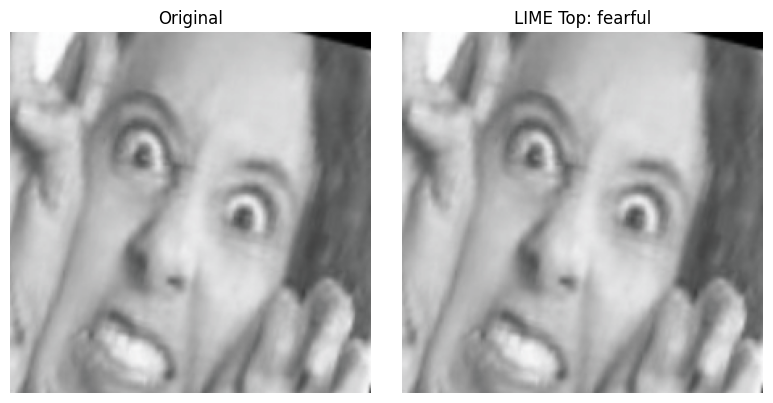

  0%|          | 0/600 [00:00<?, ?it/s]

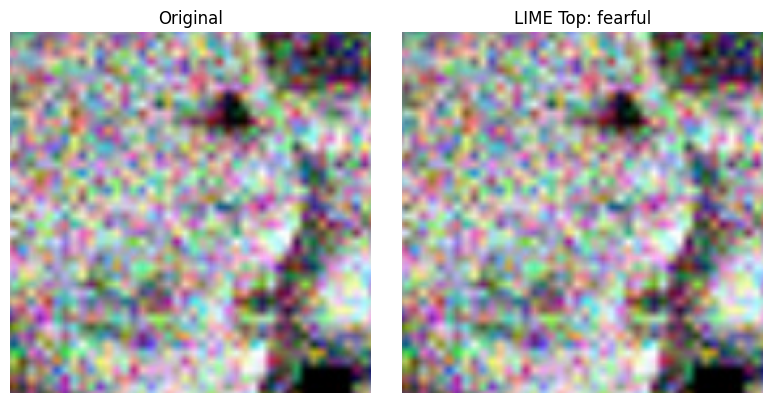

  0%|          | 0/600 [00:00<?, ?it/s]

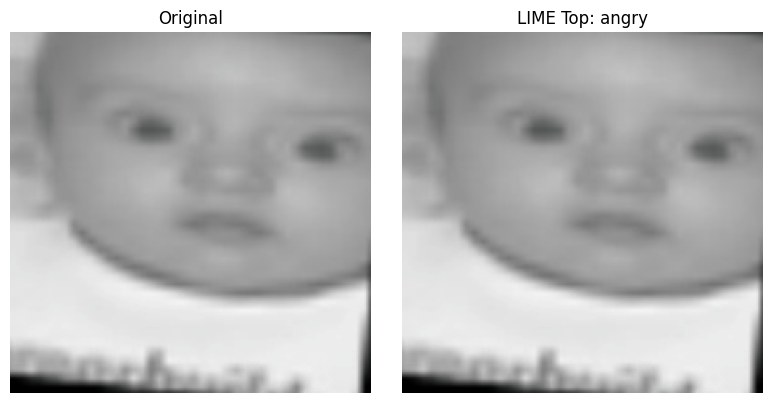

  0%|          | 0/600 [00:00<?, ?it/s]

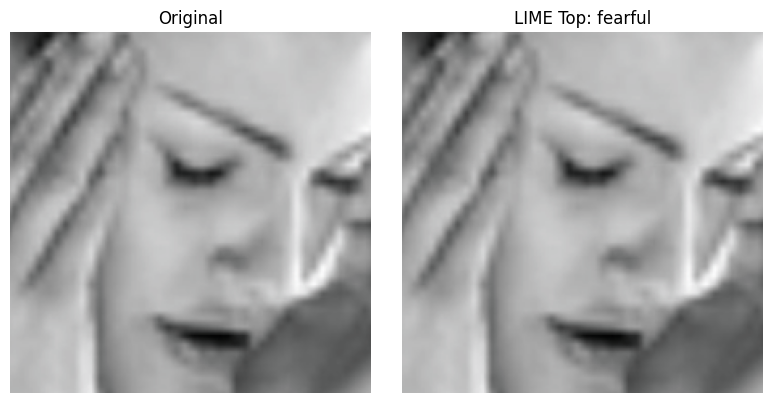

In [34]:
# --------------------------------------------------------------------------------
# Explainability: LIME
# --------------------------------------------------------------------------------
if cfg.run_lime:
    print('\nRunning LIME (small subset for speed)...')
    explainer = lime_image.LimeImageExplainer()
    def lime_predict(imgs):
        # imgs: list of HxWx3 uint8
        arr = np.stack([img.astype(np.float32)/255.0 for img in imgs], axis=0)
        return predict_fn_for_explain(arr)

    lime_idx = np.random.choice(len(test_dataset), size=min(4, len(test_dataset)), replace=False)
    for idx in lime_idx:
        img_t, _, _ = test_dataset[idx]
        img = np.transpose(img_t.numpy(), (1,2,0))
        img_rgb = (np.clip((img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)), 0, 1) * 255).astype(np.uint8)
        explanation = explainer.explain_instance(
            image=img_rgb,
            classifier_fn=lime_predict,
            top_labels=1,
            hide_color=0,
            num_samples=600,  # increase for higher fidelity
            segmentation_fn=None
        )
        top = explanation.top_labels[0]
        temp, mask = explanation.get_image_and_mask(label=top, positive_only=True, num_features=6, hide_rest=False)
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(img_rgb); plt.axis('off'); plt.title('Original')
        plt.subplot(1,2,2); plt.imshow(temp); plt.axis('off'); plt.title(f'LIME Top: {CLASSES[top]}')
        plt.tight_layout(); plt.show()

In [35]:
# --------------------------------------------------------------------------------
# ViT Attention Visualization (rollout and last-layer attention)
# --------------------------------------------------------------------------------
def vit_attention_rollout(model_vit, img_t: torch.Tensor, discard_ratio: float = 0.9):
    # Adapted rollout: aggregate attention across layers
    # img_t: 1x3xHxW
    model_vit.eval()
    attn_weights = []

    def hook_attn(module, input, output):
        # output is dict in some timm variants; unify
        # timm's Attention forward returns a tuple (x) with attn inside local variables; easier to patch with custom hook approach
        # We’ll register on module.attn_drop input: not always available; fallback to module.attn with storing context
        pass

    # More robust: forward with register_forward_hook to capture attention from module.attn
    handles = []
    for blk in getattr(model_vit, 'blocks', []):
        if hasattr(blk, 'attn'):
            def get_hook(container):
                def hook_fn(m, inp, out):
                    # Try to reconstruct attention from module attributes
                    if hasattr(m, 'attn_map'):  # unlikely
                        a = m.attn_map
                    else:
                        # As a fallback, skip if not accessible
                        a = None
                    if a is not None:
                        attn_weights.append(a.detach().cpu())
                return hook_fn
            handles.append(blk.attn.register_forward_hook(get_hook(blk.attn)))

    with torch.no_grad():
        _ = model_vit(img_t.to(device))

    for h in handles:
        h.remove()

    if len(attn_weights) == 0:
        print('Attention maps were not captured (timm attention internals vary). Showing last-layer attention via CAM as fallback.')
        return None

    # Compute rollout
    # Each attn: [B, heads, tokens, tokens]
    attn = torch.stack(attn_weights, dim=0)  # [L, B, H, T, T]
    attn = attn.mean(dim=2)  # average over heads -> [L, B, T, T]
    attn = attn.squeeze(1)   # [L, T, T]
    eye = torch.eye(attn.size(-1))
    aug_attn = attn + eye
    aug_attn = aug_attn / aug_attn.sum(dim=-1, keepdim=True)
    rollout = aug_attn[0]
    for i in range(1, aug_attn.shape[0]):
        rollout = torch.matmul(aug_attn[i], rollout)
    # rollout shape: [T, T] propagate from CLS token
    mask = rollout[0, 1:]  # exclude CLS -> patch tokens
    return mask

if cfg.run_vit_attn and cfg.model_type.startswith('vit'):
    # One image
    img_t, lab, p = test_dataset[0]
    img_t = img_t.unsqueeze(0)
    try:
        mask = vit_attention_rollout(model, img_t, discard_ratio=0.9)
        if mask is not None:
            # reshape to grid
            num_patches = mask.shape[0]
            grid = int(math.sqrt(num_patches))
            mask_img = mask.reshape(grid, grid).numpy()
            mask_img = (mask_img - mask_img.min()) / (mask_img.max() - mask_img.min() + 1e-6)
            # upscale to image
            mask_img = cv2.resize(mask_img, (cfg.img_size, cfg.img_size), interpolation=cv2.INTER_CUBIC)
            rgb = tensor_to_rgb(img_t)
            vis = show_cam_on_image(rgb, mask_img, use_rgb=True)
            plt.figure(figsize=(6,3))
            plt.subplot(1,2,1); plt.imshow(rgb); plt.axis('off'); plt.title('Image')
            plt.subplot(1,2,2); plt.imshow(vis); plt.axis('off'); plt.title('ViT Attention Rollout')
            plt.tight_layout(); plt.show()
    except Exception as e:
        print('ViT attention visualization fallback. Reason:', str(e))

In [36]:
# --------------------------------------------------------------------------------
# Export ONNX and Validate
# --------------------------------------------------------------------------------
if cfg.export_onnx:
    onnx_path = cfg.out_dir / cfg.onnx_filename
    model.eval()
    dummy = torch.randn(1, 3, cfg.img_size, cfg.img_size, device=device)
    dynamic_axes = {'input': {0: 'batch'}, 'logits': {0: 'batch'}}

    torch.onnx.export(
        model, dummy, str(onnx_path),
        input_names=['input'], output_names=['logits'],
        dynamic_axes=dynamic_axes,
        opset_version=17, do_constant_folding=True
    )
    print('Saved ONNX to:', onnx_path)

    # Validate with onnxruntime
    ort_sess = ort.InferenceSession(str(onnx_path), providers=['CPUExecutionProvider'])
    ort_outs = ort_sess.run(None, {'input': dummy.detach().cpu().numpy().astype(np.float32)})
    print('ONNXRuntime output shape:', ort_outs[0].shape)

/tmp/ipython-input-4235229030.py:10: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Saved ONNX to: /content/ann-visual-emotion/artifacts_explainability/best_model.onnx
ONNXRuntime output shape: (1, 6)
